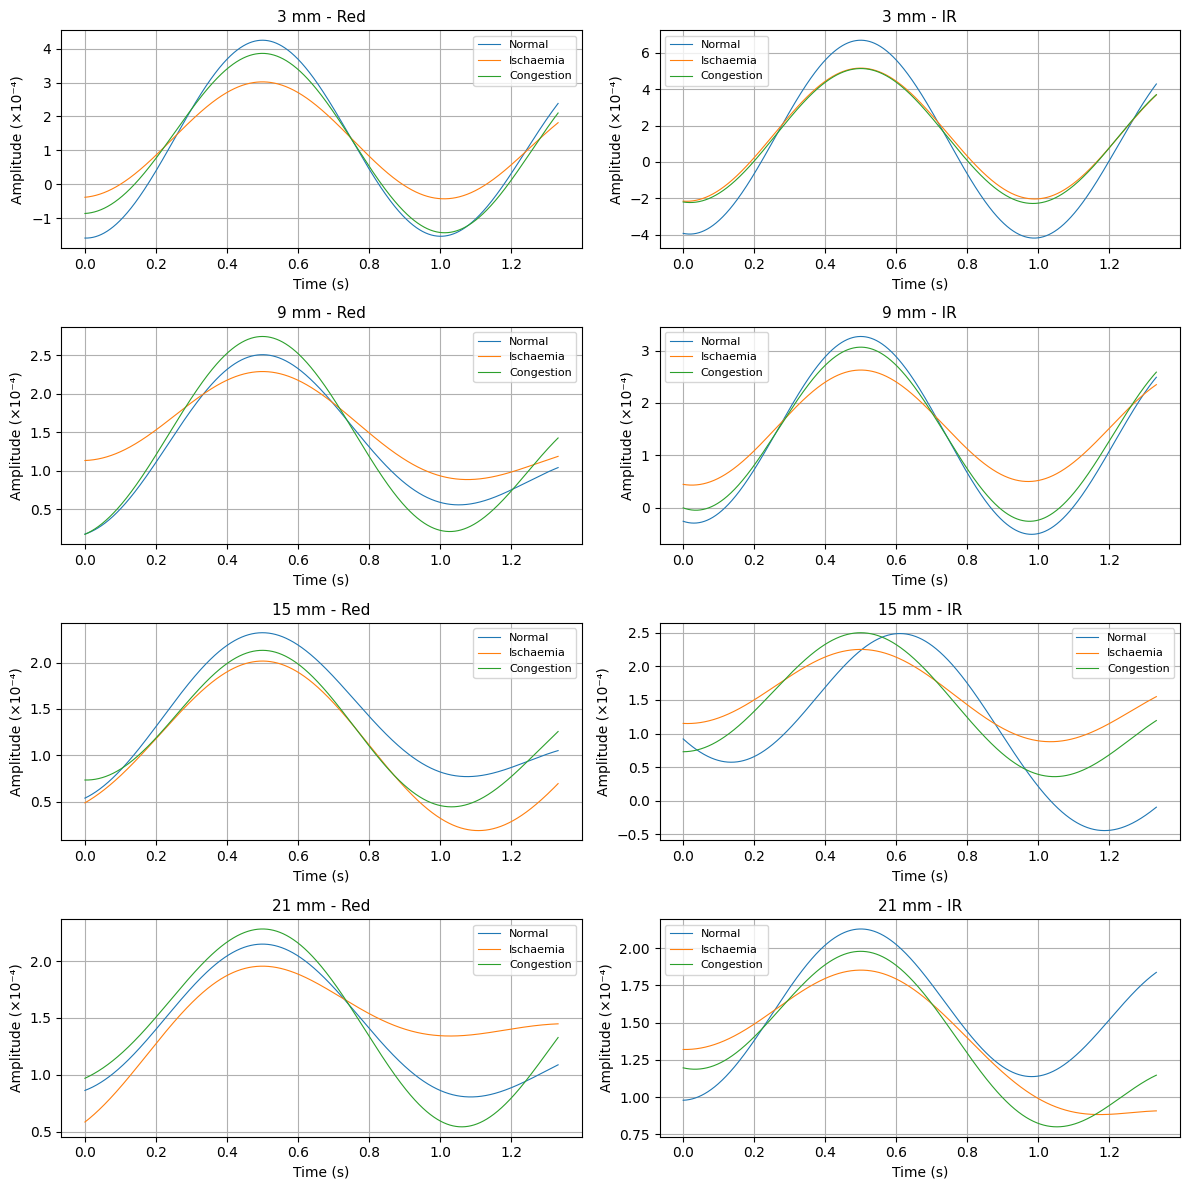

In [ ]:
#PPG波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 表示時間 [秒]
start_search = 3      # 検索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=1.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ch_label) in enumerate(channels.items()):
        ax = axes[i_depth, j_ch]

        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # --- AC/DC正規化 ---
            dc = butter_lowpass_filter(sig, fs, cutoff=0.5)
            sig_norm = (sig - dc) / (dc + 1e-8)

            # --- 強スムージング ---
            smoothed = butter_lowpass_filter(sig_norm, fs, cutoff=1.0)

            # --- 開始5秒以降の最大値（ピーク）を検出 ---
            start_idx = int(start_search * fs)
            if start_idx >= len(smoothed):
                start_idx = 0
            max_idx = np.argmax(smoothed[start_idx:]) + start_idx

            # --- 表示区間（ピーク中心 → 前にずらす） ---
            view_len = int(view_sec * fs)
            pre_offset = int(view_len * 0.25)  # ピークから0.75秒前に開始
            start_plot = max(max_idx - pre_offset, 0)
            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            # --- 表示は先頭2/3まで ---
            cut_len = int(view_len * 2 / 3)
            seg = smoothed[start_plot:start_plot + cut_len]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg * 1e4, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ch_label}", fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (×10⁻⁴)")
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

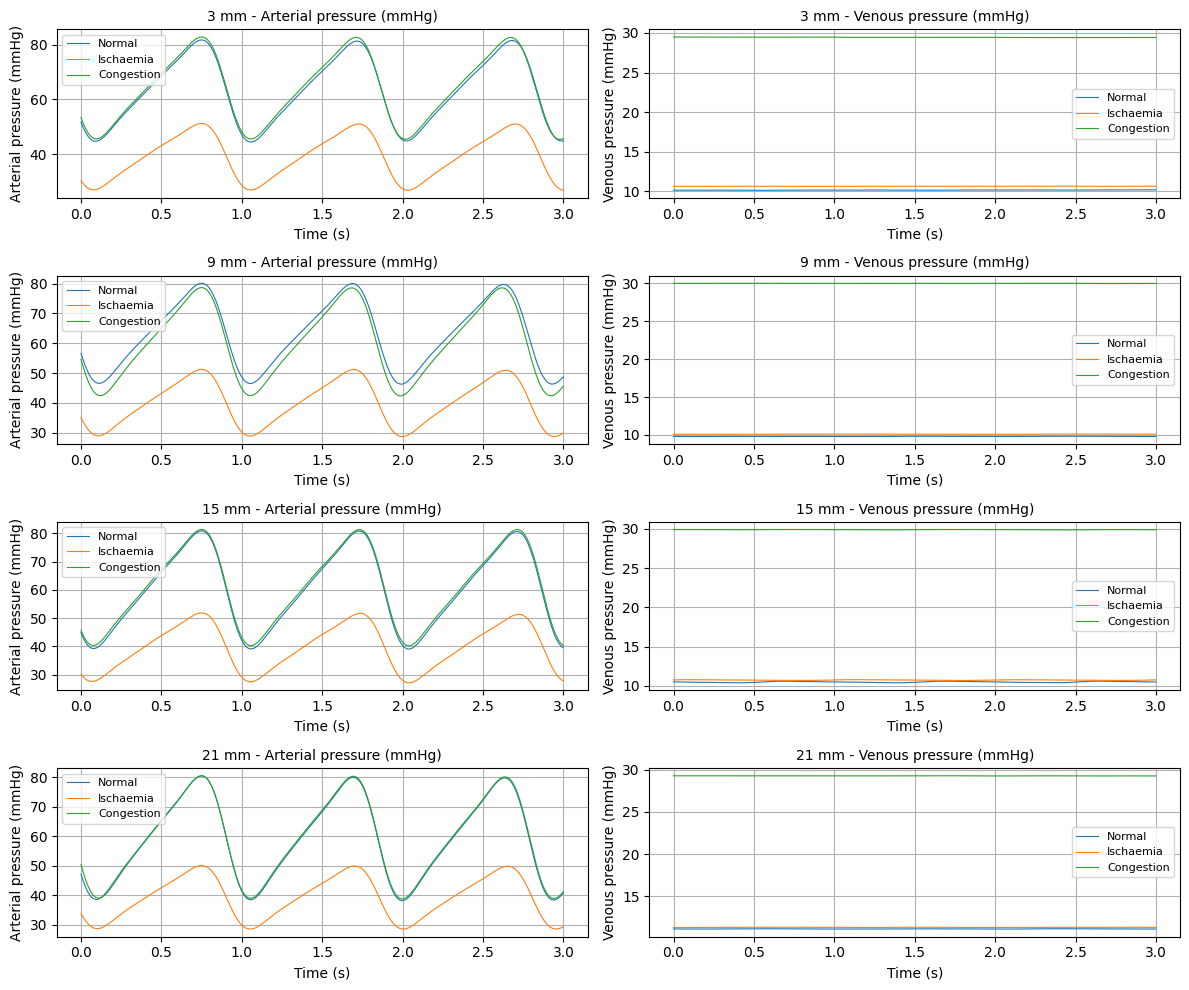

In [ ]:
#圧力波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 3          # 表示時間 [秒]
start_search = 5      # ピーク探索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
pressure_channels = {"p2_mmhg": "Arterial pressure (mmHg)", "p1_mmhg": "Venous pressure (mmHg)"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=3.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ylabel) in enumerate(pressure_channels.items()):
        ax = axes[i_depth, j_ch]
        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # スムージング
            smoothed = butter_lowpass_filter(sig, fs, cutoff=3.0)

            # 表示区間の決定
            view_len = int(view_sec * fs)
            start_idx = int(start_search * fs)

            if col_name == "p2_mmhg":  # 動脈 → ピーク揃え
                max_idx = np.argmax(smoothed[start_idx:]) + start_idx
                pre_offset = int(view_len * 0.25)
                start_plot = max(max_idx - pre_offset, 0)
            else:  # 静脈 → 一律スタート
                start_plot = start_idx

            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            seg = smoothed[start_plot:end_plot]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ylabel}", fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [128]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product 
import io # CSV出力の補助用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20    # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
depths_to_process = [3, 9, 15, 21] # ★処理対象の深さリスト★
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2) # 10, 12, ..., 20 Hz
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) # 50, 100, 150, 200 Hz


# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と結果の統合 =====
# ----------------------------------------------------------------------
final_results_list = []
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

for depth in depths_to_process:
    for channel_key, channel_name in channels.items():
        for state_key, state_name in state_map.items():
            
            current_best_snr_db = -math.inf 
            best_cutoffs = (0, 0)
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            signal_amplitude = 0
            
            try:
                # RAWデータを読み込み (float64を強制)
                df = pd.read_csv(file_name) 
                signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
                
                # 信号振幅 (RAW Pk-Pk) は固定
                signal_amplitude = calculate_amplitude(signal_raw)
                
                # --- グリッドサーチの実行 ---
                for lowcut, highcut in all_combinations:
                    if lowcut >= highcut:
                        continue 
                    
                    # 1. ノイズ振幅 (Noise Amplitude) の計算
                    noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                    noise_amplitude = calculate_amplitude(noise_ac)
                    
                    # 2. S/N比の計算
                    if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                        snr_ratio = signal_amplitude / noise_amplitude
                        snr_db = 20 * math.log10(snr_ratio)
                        
                        # 3. 最適解の更新
                        if snr_db > current_best_snr_db:
                            current_best_snr_db = snr_db
                            best_cutoffs = (lowcut, highcut)
                    
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                continue
            except KeyError:
                print(f"Warning: Column '{channel_key}' not found in file: {file_name}")
                continue
            
            # 結果をリストに追加 (指数表記なし)
            if current_best_snr_db != -math.inf:
                # 指数表記を避けるために通常の浮動小数点形式に変換
                final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}", # 信号振幅 (10桁精度)
                    f"{current_best_snr_db:.2f}",
                    f"{best_cutoffs[0]} - {best_cutoffs[1]} Hz"
                ])
            else:
                 final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}",
                    "N/A",
                    "N/A"
                ])


# ----------------------------------------------------------------------
# ===== CSVファイルへの保存 =====
# ----------------------------------------------------------------------
output_df = pd.DataFrame(final_results_list, columns=[
    'Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 
    'Max S/N Ratio (dB)', 'Optimal Noise BPF'
])

output_file = 'ppg_snr_grid_search_results.csv'
# to_csvで指数表記を防ぐための設定（float_formatを使用）
output_df.to_csv(output_file, index=False, float_format='%.10f')

print("="*80)
print(f"✅ 全深さのグリッドサーチが完了しました。")
print(f"✅ 結果は {output_file} に保存されました (指数表記なし)。")
print("="*80)
# コンソールにも表形式で一部表示
print("\n--- サマリー結果 (CSVに保存されたデータ) ---")
print(tabulate(output_df.head(25), headers='keys', tablefmt='fancy_grid', showindex=False))

✅ 全深さのグリッドサーチが完了しました。
✅ 結果は ppg_snr_grid_search_results.csv に保存されました (指数表記なし)。

--- サマリー結果 (CSVに保存されたデータ) ---
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            3 │ Red_raw   │ Normal     │               0.0073994  │                14.89 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Ischaemia  │               0.00559066 │                13.34 │ 18 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Congestion │               0.009537   │                17.79 │ 

In [129]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, detrend, butter, filtfilt
from pathlib import Path

# ========= パラメータ =========
fs = 2000             # サンプリング周波数
target_amp = 1.0      # AGC後の目標振幅
gain_limit = (0.1,10) # AGCゲインの上下限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# --- ノイズ除去 LPF パラメータ（グリッドサーチ結果） ---
DEFAULT_LPF_CUTOFF = 20.0 
LPF_ORDER = 4
# 18 Hz LPFを適用すべきデータ (RAW信号名基準)
OPTIMAL_18HZ_CUTOFF = [
    (3, "Ischaemia", "ppgA_Red_raw"),
    (3, "Congestion", "ppgA_Red_raw"),
    (9, "Ischaemia", "ppgA_Red_raw"),
    (9, "Ischaemia", "ppgA_IR_raw"),
]

# --- BPF（bpm推定用） ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

# --- LPF（ノイズ除去用） ---
def lowpass_filter_noise_reduction(sig, fs, high_cutoff, order=LPF_ORDER):
    nyq = fs / 2
    b, a = butter(order, high_cutoff / nyq, btype='low')
    return filtfilt(b, a, sig)

# --- bpm推定（フォールバック用） ---
def estimate_bpm(signal, fs=2000):
    """IR信号からbpmを推定"""
    sig = pd.Series(signal).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig) * 0.3, np.ptp(sig)*0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs*0.5))
    if len(peaks) < 2:
        return np.nan
    bpm = len(peaks) / (len(sig)/fs/60)
    return bpm

# --- AGC 関数 ---
def apply_agc(signal, fs, window_sec, target_amp, gain_limit):
    """一定区間ごとにAGCをかけて振幅をそろえる"""
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg)==0: continue
        # RMS振幅に基づくゲイン計算
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# --- BPMデータの読み込みと取得 ---
try:
    df_bpm = pd.read_csv('bpm_summary.csv')
    # 列名が depth, state, bpm の順であることを前提
    df_bpm.columns = ['Depth', 'State', 'BPM'] 
    print("✅ bpm_summary.csv を読み込みました。")
except FileNotFoundError:
    df_bpm = None
    print("❌ bpm_summary.csv が見つかりません。estimate_bpmを使用します。")

def get_individual_bpm(depth, state_name, df_bpm_data):
    if df_bpm_data is None:
        return np.nan
    match = df_bpm_data[(df_bpm_data['Depth'] == depth) & 
                        (df_bpm_data['State'] == state_name)]
    return match['BPM'].iloc[0] if not match.empty else np.nan

# ========= 全ファイル処理 =========
for depth in depths:
    for i_state, state_name in state_map.items():
        input_file = f"{depth}mm_adjusted_data{i_state}.csv"
        # ★出力ファイル名を AGC に変更★
        output_file = f"{depth}mm_AGC_data{i_state}.csv"  

        # ファイル読み込み
        try:
            df = pd.read_csv(input_file)
        except FileNotFoundError:
            print(f"[警告] {input_file} が存在しません")
            continue
            
        if not {"ppgA_Red_raw","ppgA_IR_raw"}.issubset(df.columns):
            print(f"[警告] {input_file} に必要な列がありません")
            continue

        # --- 1. BPMの取得 (個別BPM優先) ---
        bpm = get_individual_bpm(depth, state_name, df_bpm)
        
        if np.isnan(bpm) or bpm <= 0:
            # 個別BPMが取得できなかった場合、RAW IRデータで推定（フォールバック）
            bpm = estimate_bpm(df["ppgA_IR_raw"].values, fs)

        if np.isnan(bpm) or bpm <= 0:
            window_sec = 1.0
            print(f"[警告] {input_file}: BPM推定失敗。デフォルト {window_sec}s 窓でAGCを実行。")
        else:
            # ★BPMに基づいたPPG一周期をAGC窓長とする★
            window_sec = 60.0 / bpm
            print(f"{input_file}: BPM={bpm:.1f}, AGC_window={window_sec:.3f} s")
            
        # --- 2. AGC適用（ノイズ除去を組み込み） ---
        for ch_raw in ["ppgA_Red_raw", "ppgA_IR_raw"]:
            ch_agc = ch_raw.replace("_raw", "_AGC")
            
            raw_sig = df[ch_raw].values.astype(float)
            
            # --- LPF カットオフ周波数の個別決定 ---
            current_cutoff = DEFAULT_LPF_CUTOFF
            if (depth, state_name, ch_raw) in OPTIMAL_18HZ_CUTOFF:
                 current_cutoff = 18.0
            
            # ★★★ AGC適用前のノイズ除去 LPF ★★★
            # LPFを適用する前に、NaN/Infを補間（安全策）
            sig_series = pd.Series(raw_sig).replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)
            
            filtered_sig = lowpass_filter_noise_reduction(sig_series.values, fs, high_cutoff=current_cutoff)
            
            # ★★★ AGC適用 ★★★
            df[ch_agc] = apply_agc(filtered_sig, fs, window_sec, target_amp, gain_limit)

        # 保存
        # AGC2のファイルとして保存
        df.to_csv(output_file, index=False)
        print(f"[保存完了] {output_file}")
print("\n✅ 全てのAGCファイルが作成されました。このファイルを次のSQI計算に使用してください。")


✅ bpm_summary.csv を読み込みました。
3mm_adjusted_data1.csv: BPM=60.8, AGC_window=0.987 s
[保存完了] 3mm_AGC_data1.csv
3mm_adjusted_data2.csv: BPM=62.7, AGC_window=0.957 s
[保存完了] 3mm_AGC_data2.csv
3mm_adjusted_data3.csv: BPM=62.3, AGC_window=0.963 s
[保存完了] 3mm_AGC_data3.csv
9mm_adjusted_data1.csv: BPM=62.3, AGC_window=0.963 s
[保存完了] 9mm_AGC_data1.csv
9mm_adjusted_data2.csv: BPM=64.7, AGC_window=0.927 s
[保存完了] 9mm_AGC_data2.csv
9mm_adjusted_data3.csv: BPM=64.3, AGC_window=0.933 s
[保存完了] 9mm_AGC_data3.csv
15mm_adjusted_data1.csv: BPM=60.4, AGC_window=0.993 s
[保存完了] 15mm_AGC_data1.csv
15mm_adjusted_data2.csv: BPM=60.8, AGC_window=0.987 s
[保存完了] 15mm_AGC_data2.csv
15mm_adjusted_data3.csv: BPM=60.8, AGC_window=0.987 s
[保存完了] 15mm_AGC_data3.csv
21mm_adjusted_data1.csv: BPM=65.1, AGC_window=0.922 s
[保存完了] 21mm_AGC_data1.csv
21mm_adjusted_data2.csv: BPM=63.2, AGC_window=0.949 s
[保存完了] 21mm_AGC_data2.csv
21mm_adjusted_data3.csv: BPM=63.2, AGC_window=0.949 s
[保存完了] 21mm_AGC_data3.csv

✅ 全てのAGCファイルが作成されました。この

In [130]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import savgol_filter, correlate, find_peaks, detrend, butter, filtfilt
from scipy.fft import rfft, rfftfreq

# ===== パラメータ =====
fs = 2000               # サンプリング周波数 [Hz]
default_window_sec = 8  # bpm推定失敗時のデフォルト窓長 [秒]
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
# ★SQIのロバスト性向上パラメータ
SAVGOL_WINDOW = 101     # Savitzky-Golay 窓長 (101点に強化)

# --- BPMデータの読み込みと取得（個別BPMによる窓長設定のため） ---
try:
    df_bpm = pd.read_csv('bpm_summary.csv')
    df_bpm.columns = ['Depth', 'State', 'BPM'] 
    print("✅ bpm_summary.csv を読み込みました。")
except FileNotFoundError:
    df_bpm = None
    print("❌ bpm_summary.csv が見つかりません。")

def get_individual_bpm(depth, state_name, df_bpm_data):
    if df_bpm_data is None:
        return np.nan
    match = df_bpm_data[(df_bpm_data['Depth'] == depth) & 
                        (df_bpm_data['State'] == state_name)]
    return match['BPM'].iloc[0] if not match.empty else np.nan

# --- SQI 関数（変更なし） ---
def compute_sqi(segment, fs):
    seg = np.asarray(segment, dtype=float)
    if seg.size < 10:
        return np.nan
    amp = np.ptp(seg)
    noise = np.std(seg)
    snr_norm = min(amp/(noise+1e-8)/10, 1)
    # 自己相関
    corr = correlate(seg - np.mean(seg), seg - np.mean(seg), mode='full')
    # RuntimeWarning対策として、分母にnp.abs(np.max(corr))を使用
    max_corr_abs = np.abs(np.max(corr))
    corr = corr[len(corr)//2:] / (max_corr_abs + 1e-8)
    lag_min = max(1, int(0.2*len(seg)))
    lag_max = max(lag_min+1, int(0.6*len(seg)))
    lag_max = min(lag_max, len(corr)-1)
    ac_norm = np.clip(np.max(corr[lag_min:lag_max]), 0, 1) if lag_max>lag_min else 0
    # 周波数優位
    freqs = rfftfreq(len(seg), 1/fs)
    fft_vals = np.abs(rfft(seg))
    mask = (freqs>0.5) & (freqs<3)
    dom_norm = 0
    if np.any(mask):
        band = fft_vals[mask]
        dom = np.max(band)/(np.sum(band)+1e-8)
        dom_norm = np.clip(dom*5, 0, 1)
    # SNRをやや重め(0.5)に
    return 0.5*snr_norm + 0.25*ac_norm + 0.25*dom_norm

records = []

for depth in depths:
    for i_state, state_name in state_map.items():
        # ★AGC2ファイルから読み込み★
        file = Path(f"{depth}mm_AGC_data{i_state}.csv") 
        if not file.exists():
            print(f"[警告] {file} が存在しません。AGCファイルを作成してから実行してください。")
            continue

        df = pd.read_csv(file)
        
        # --- BPM取得とウィンドウサイズ設定（個別BPM優先） ---
        bpm = get_individual_bpm(depth, state_name, df_bpm)
        
        if np.isnan(bpm) or bpm <= 0:
            window_sec = default_window_sec
            print(f"  {file.name}: BPMデータ不足または無効値 → デフォルト {default_window_sec:.1f}s 窓を使用")
        else:
            # BPMに基づき、最適な窓長を計算（3拍分を維持）
            window_sec = max(3.0, 60.0 / bpm * 3.0) 
            print(f"  {file.name}: 取得BPM={bpm:.1f}, window_sec={window_sec:.2f}s")
        # ----------------------------------------

        # ★AGC済みデータ列を使用★
        for ch in ["ppgA_Red_AGC", "ppgA_IR_AGC"]:
            if ch not in df.columns:
                print(f"[警告] {file.name}: {ch} 列がありません")
                continue
            
            sig_series = df[ch].astype(float)
            
            # ★★★ 修正: NaN/Infの補間処理を適用 (AGC2の出力にも安全策として適用) ★★★
            sig_series = sig_series.replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)
            sig = sig_series.values
            
            # --- 平滑化（Savitzky-Golay強化）---
            # AGC2のデータは既にLPF処理されているが、SQI安定化のためSavitzky-Golayを適用
            wl = SAVGOL_WINDOW if len(sig) > SAVGOL_WINDOW else (len(sig)//2)*2 - 1
            sig_filt = savgol_filter(sig, wl, 3) if wl and wl>=5 else sig

            step = max(1, int(round(window_sec * fs)))
            hop = max(1, step // 2)  # 50%オーバーラップ
            sqis = []

            # SQIのウィンドウ処理
            if len(sig_filt) <= step:
                sqis.append(compute_sqi(sig_filt, fs))
            else:
                for start in range(0, len(sig_filt) - step + 1, hop):
                    seg = sig_filt[start:start + step]
                    sqis.append(compute_sqi(seg, fs))
                tail = len(sig_filt) - (start + step) if sqis else len(sig_filt)
                if tail >= int(0.5 * step):
                    seg = sig_filt[-step:]
                    sqis.append(compute_sqi(seg, fs))

            sqi_arr = np.array(sqis, dtype=float)
            valid_mask = ~np.isnan(sqi_arr)
            n_valid = int(valid_mask.sum())
            n_total = int(sqi_arr.size)

            mean_sqi = float(np.nanmean(sqi_arr)) if n_valid > 0 else np.nan
            std_sqi  = float(np.nanstd(sqi_arr))  if n_valid > 0 else np.nan
            valid_ratio = float(n_valid / n_total) if n_total > 0 else 0.0

            records.append({
                "Depth": depth,
                "Condition": state_name,
                "Channel": "Red" if "Red" in ch else "IR",
                "SQI_mean": mean_sqi,
                "SQI_std": std_sqi,
                "Valid_ratio": valid_ratio,
                "n_windows": n_total
            })

df_sqi = pd.DataFrame(records)
# ★ファイル名修正: SQI_summary.csv を使用（上書き防止）
df_sqi.to_csv("SQI_summary.csv", index=False)
print("\n" + "="*80)
print("✅ AGCデータに基づく SQI 計算が完了し、SQI_summary.csv を出力しました。")
print("="*80)
print(df_sqi.round(3))

✅ bpm_summary.csv を読み込みました。
  3mm_AGC_data1.csv: 取得BPM=60.8, window_sec=3.00s
  3mm_AGC_data2.csv: 取得BPM=62.7, window_sec=3.00s
  3mm_AGC_data3.csv: 取得BPM=62.3, window_sec=3.00s
  9mm_AGC_data1.csv: 取得BPM=62.3, window_sec=3.00s
  9mm_AGC_data2.csv: 取得BPM=64.7, window_sec=3.00s
  9mm_AGC_data3.csv: 取得BPM=64.3, window_sec=3.00s
  15mm_AGC_data1.csv: 取得BPM=60.4, window_sec=3.00s
  15mm_AGC_data2.csv: 取得BPM=60.8, window_sec=3.00s
  15mm_AGC_data3.csv: 取得BPM=60.8, window_sec=3.00s
  21mm_AGC_data1.csv: 取得BPM=65.1, window_sec=3.00s
  21mm_AGC_data2.csv: 取得BPM=63.2, window_sec=3.00s
  21mm_AGC_data3.csv: 取得BPM=63.2, window_sec=3.00s

✅ AGCデータに基づく SQI 計算が完了し、SQI_summary.csv を出力しました。
    Depth   Condition Channel  SQI_mean  SQI_std  Valid_ratio  n_windows
0       3      Normal     Red     0.580    0.010          1.0         19
1       3      Normal      IR     0.562    0.002          1.0         19
2       3   Ischaemia     Red     0.586    0.010          1.0         19
3       3   Ischaemia   

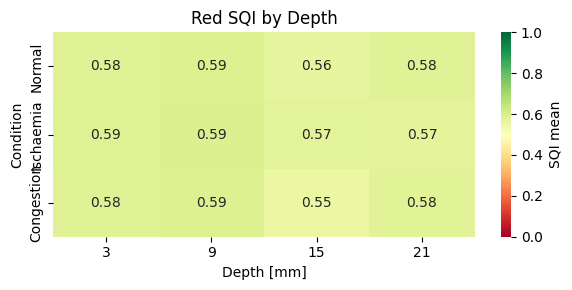

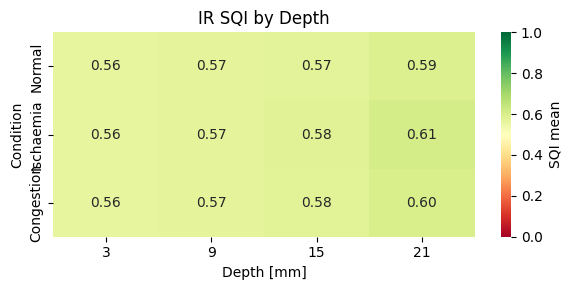

In [131]:
#SQIヒートマップの描画

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== SQI 集計結果の読み込み =====
df_sqi = pd.read_csv("SQI_summary.csv")

# ===== Red と IR に分ける =====
df_red = df_sqi[df_sqi["Channel"] == "Red"]
df_ir  = df_sqi[df_sqi["Channel"] == "IR"]

# ===== Pivotしてヒートマップ用の表を作成 =====
red_pivot = df_red.pivot(index="Condition", columns="Depth", values="SQI_mean")
ir_pivot  = df_ir.pivot(index="Condition", columns="Depth", values="SQI_mean")

# Condition の表示順を統一
order = ["Normal", "Ischaemia", "Congestion"]
red_pivot = red_pivot.reindex(order)
ir_pivot  = ir_pivot.reindex(order)

# ===== ヒートマップ描画 =====
def plot_sqi_heatmap(data, title):
    plt.figure(figsize=(6,3))
    sns.heatmap(
        data,
        annot=True, fmt=".2f",
        cmap="RdYlGn", center=0.5,  # 0.5 を基準色に
        vmin=0, vmax=1,             # SQI の範囲を 0〜1 に固定
        cbar_kws={"label": "SQI mean"}
    )
    plt.title(title)
    plt.xlabel("Depth [mm]")
    plt.ylabel("Condition")
    plt.tight_layout()
    plt.show()

plot_sqi_heatmap(red_pivot, "Red SQI by Depth")
plot_sqi_heatmap(ir_pivot,  "IR SQI by Depth")

In [132]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

# ===== パラメータ =====
depths = [3, 9, 15, 21]
group_names = ["Normal", "Ischaemia", "Congestion"]

# ===== 結果格納用リスト =====
results = []

# ===== 各深さについてKruskal-Wallis検定 =====
for depth in depths:
    # ファイル読み込み（AGC済みデータを使用）
    files = [
        (f"{depth}mm_AGC_data1.csv", "Normal"),
        (f"{depth}mm_AGC_data2.csv", "Ischaemia"),
        (f"{depth}mm_AGC_data3.csv", "Congestion"),
    ]

    red_groups = []
    ir_groups = []
    
    for file, _ in files:
        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].values
        ir = df["ppgA_IR_AGC"].values

        # 窓ごとの振幅（最大-最小）
        fs = 2000
        window_sec = 1
        step = fs * window_sec
        n_win = len(red) // step

        red_amp = []
        ir_amp = []
        for w in range(n_win):
            s = w * step
            e = s + step
            rseg = red[s:e]
            iseg = ir[s:e]
            if len(rseg) < 2 or len(iseg) < 2:
                continue
            red_amp.append(rseg.max() - rseg.min())
            ir_amp.append(iseg.max() - iseg.min())

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # 正規化（IR Normalの平均 = 0.5に）
    normal_ir_mean = np.mean(ir_groups[0])
    scale_factor = 0.5 / normal_ir_mean
    red_groups_scaled = [[v * scale_factor for v in g] for g in red_groups]
    ir_groups_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

    # Kruskal-Wallis検定
    stat_red, p_red = kruskal(*red_groups_scaled)
    stat_ir,  p_ir  = kruskal(*ir_groups_scaled)

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "Red",
        "Chi-Squared": stat_red,
        "df": len(red_groups_scaled)-1,
        "p-Value": p_red
    })

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "IR",
        "Chi-Squared": stat_ir,
        "df": len(ir_groups_scaled)-1,
        "p-Value": p_ir
    })

# ===== 結果の保存 =====
df_result = pd.DataFrame(results)
df_result.to_csv("KW_result.csv", index=False)

# ===== 結果の表示 =====
print("✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):")
print(df_result.round(4))


✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):
  Depth Channel  Chi-Squared  df  p-Value
0   3mm     Red      60.3569   2   0.0000
1   3mm      IR      72.6409   2   0.0000
2   9mm     Red      34.8158   2   0.0000
3   9mm      IR      77.0673   2   0.0000
4  15mm     Red       9.5323   2   0.0085
5  15mm      IR      79.1209   2   0.0000
6  21mm     Red      11.0858   2   0.0039
7  21mm      IR      60.5660   2   0.0000


In [133]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm
import os

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
group_names = list(states.values())

# ===== Dunn test関数 =====
def dunn_test(groups, group_labels):
    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i, g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)
    ties_correction = 1 - (np.sum(np.bincount(ranks.astype(int))[1:]**3 - np.bincount(ranks.astype(int))[1:]) / (n**3 - n))
    if ties_correction <= 0: ties_correction = 1

    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id==i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i]/n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt((n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction)
            Z = diff / SE
            p = 2 * (1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{group_labels[i]} vs {group_labels[j]}",
                "Z": Z,
                "p_Unadj": p
            })

    df = pd.DataFrame(results)
    df["p_Adj"] = np.minimum(df["p_Unadj"] * len(df), 1.0)
    return df

# ===== 結果格納用 =====
all_results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC_{data_key}.csv"
        if not os.path.exists(file):
            print(f"⚠️ File not found: {file}")
            continue

        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].dropna().values
        ir  = df["ppgA_IR_AGC"].dropna().values

        step = int(fs * window_sec)
        red_amp = [(red[i:i+step].max() - red[i:i+step].min())
                   for i in range(0, len(red) - step, step)]
        ir_amp = [(ir[i:i+step].max() - ir[i:i+step].min())
                  for i in range(0, len(ir) - step, step)]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ========== Dunn検定 (Red) ==========
    df_dunn_red = dunn_test(red_groups, group_names)
    df_dunn_red.insert(1, "Channel", "Red")
    df_dunn_red.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_red)

    # ========== Dunn検定 (IR) ==========
    df_dunn_ir = dunn_test(ir_groups, group_names)
    df_dunn_ir.insert(1, "Channel", "IR")
    df_dunn_ir.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_ir)

# ===== 結果統合・保存 =====
df_all = pd.concat(all_results, ignore_index=True)
df_all = df_all[["Comparison", "Channel", "Depth", "Z", "p_Unadj", "p_Adj"]]
df_all = df_all.rename(columns={
    "p_Unadj": "p (Unadjusted)",
    "p_Adj": "p (Adjusted)"
})

# 表示
print("\n=== Dunn post-hoc test results across all depths ===")
print(df_all.round(4))

# 保存
df_all.to_csv("dunn_posthoc_all_depths.csv", index=False)
print("\n✅ Dunn test results saved to 'dunn_posthoc_all_depths.csv'")



=== Dunn post-hoc test results across all depths ===
                 Comparison Channel Depth       Z  p (Unadjusted)  \
0       Normal vs Ischaemia     Red   3mm  7.1753          0.0000   
1      Normal vs Congestion     Red   3mm  1.0081          0.3134   
2   Ischaemia vs Congestion     Red   3mm -6.1672          0.0000   
3       Normal vs Ischaemia      IR   3mm  8.4947          0.0000   
4      Normal vs Congestion      IR   3mm  4.8478          0.0000   
5   Ischaemia vs Congestion      IR   3mm -3.6469          0.0003   
6       Normal vs Ischaemia     Red   9mm  4.4920          0.0000   
7      Normal vs Congestion     Red   9mm -1.0674          0.2858   
8   Ischaemia vs Congestion     Red   9mm -5.5594          0.0000   
9       Normal vs Ischaemia      IR   9mm  8.7764          0.0000   
10     Normal vs Congestion      IR   9mm  4.2103          0.0000   
11  Ischaemia vs Congestion      IR   9mm -4.5661          0.0000   
12      Normal vs Ischaemia     Red  15mm  2.3275

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolo

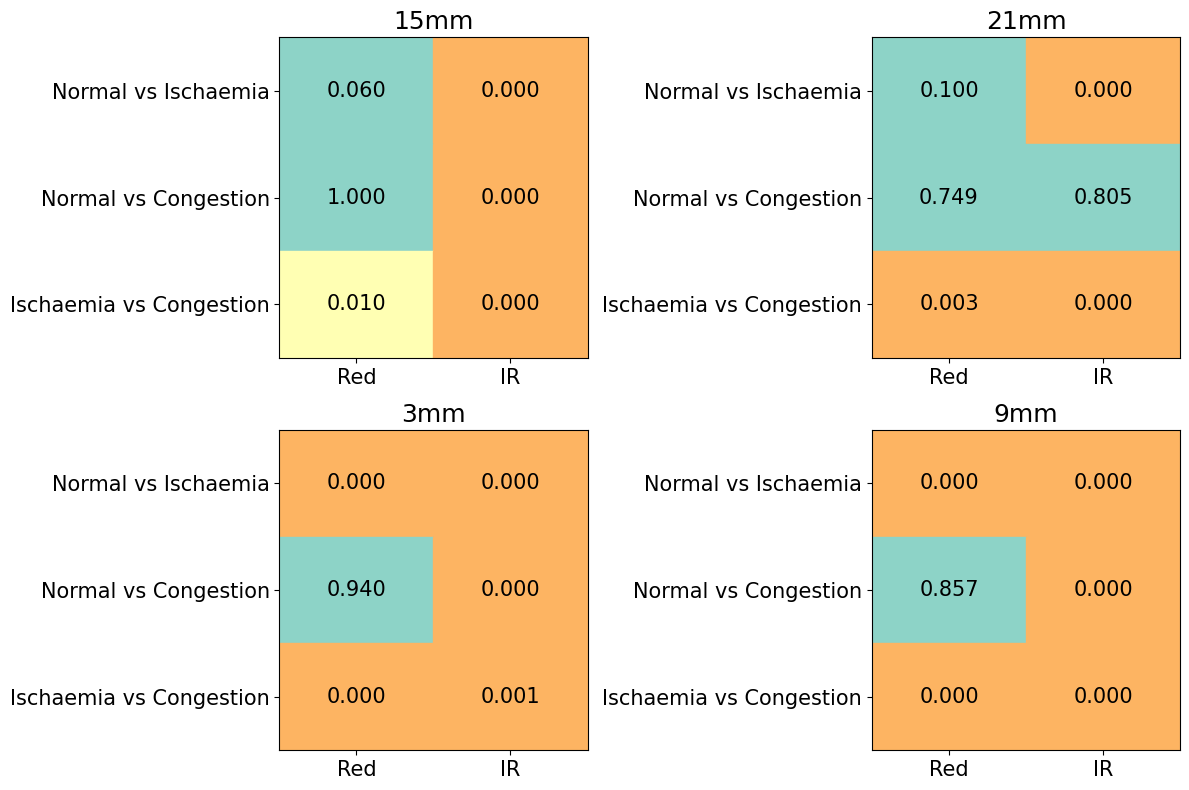

In [134]:
# 再度必要なパッケージをインポートしてコードを実行

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ファイル読み込み
df = pd.read_csv("dunn_posthoc_all_depths.csv")

# 深さごとのデータに分割
depths = df["Depth"].unique()
depths.sort()

# 比較軸とチャネルの順序を定義
comparisons = ["Normal vs Ischaemia", "Normal vs Congestion", "Ischaemia vs Congestion"]
channels = ["Red", "IR"]

# 色のマップ関数：p値に応じて色を設定
def get_color(p):
    if p < 0.01:
        return "#fdb462"  # 優しい青緑
    elif p < 0.05:
        return "#ffffb3"  # 優しい黄色
    else:
        return "#8dd3c7"  # 優しいオレンジ

# プロット準備
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, depth in enumerate(depths):
    ax = axes[idx]
    sub_df = df[df["Depth"] == depth]

    # 描画用マトリクス作成
    heatmap_data = pd.DataFrame(index=comparisons, columns=channels)

    for _, row in sub_df.iterrows():
        heatmap_data.loc[row["Comparison"], row["Channel"]] = row["p (Adjusted)"]

    # 数値のp値を float で保存し、色塗り用に用いる
    p_values = heatmap_data.astype(float)

    # 手動で heatmap 描画（p値に応じた背景色、文字重ね）
    for i, comp in enumerate(comparisons):
        for j, ch in enumerate(channels):
            p_val = p_values.loc[comp, ch]
            color = get_color(p_val)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
            ax.text(j + 0.5, i + 0.5, f"{p_val:.3f}", ha='center', va='center', fontsize=15)

    # 軸設定
    ax.set_xticks(np.arange(len(channels)) + 0.5)
    ax.set_yticks(np.arange(len(comparisons)) + 0.5)
    ax.set_xticklabels(channels, fontsize=15)
    ax.set_yticklabels(comparisons, fontsize=15)
    ax.set_xlim(0, len(channels))
    ax.set_ylim(0, len(comparisons))
    ax.set_title(f"{depth}", fontsize=18)
    ax.invert_yaxis()
    ax.set_aspect('auto')  # 自動で長方形化
    ax.grid(False)

plt.tight_layout()
plt.show()


In [135]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks, detrend, butter, filtfilt
from sklearn.metrics import roc_auc_score, roc_curve

# ========= 基本設定 =========
fs = 2000  # Hz
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
channels = {"ppgA_Red_AGC": "Red", "ppgA_IR_AGC": "IR"} 

# --- バンドパスフィルタ (bpm 推定用) ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, sig)

# --- bpm 推定 ---
def estimate_bpm(signal, fs=2000):
    sig = pd.Series(signal, dtype=float).interpolate().fillna(0).values
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    prom = max(np.std(sig) * 0.3, np.ptp(sig) * 0.05)
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs * 0.5))
    if len(peaks) < 2:
        return np.nan
    duration_sec = len(sig) / fs
    bpm = len(peaks) / (duration_sec / 60.0)
    return bpm

# --- 1拍ごとの特徴抽出 ---
def extract_pulse_features(signal, fs, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs * dist))
    feats = []
    if len(peaks) < 2:
        return []
    for p in peaks:
        left = max(0, p - int(0.5 * fs))
        right = min(len(signal), p + int(0.5 * fs))
        seg = signal[left:right]
        if len(seg) < 5:
            continue
        peak_idx = np.argmax(seg)
        trough_idx = np.argmin(seg[:peak_idx+1])
        next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])
        if trough_idx < peak_idx < next_trough_idx:
            rise = (peak_idx - trough_idx) / fs
            fall = (next_trough_idx - peak_idx) / fs
            baseline = seg[trough_idx]
            peak_val = seg[peak_idx]
            half = baseline + 0.5 * (peak_val - baseline)
            seg_pw = seg[trough_idx:next_trough_idx+1]
            above = np.where(seg_pw >= half)[0]
            pw = (above[-1] - above[0]) / fs if len(above) > 1 else np.nan
            amp = peak_val - baseline
            feats.append((rise, fall, pw, amp))
    return feats

# ========= データ読み込み & 特徴抽出 =========
records = []
pulse_id_counter = 0

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv")
        if not file.exists():
            print(f"⚠️ File not found: {file}")
            continue
            
        df = pd.read_csv(file)

        # --- bpm を IR 信号から推定 ---
        if "ppgA_IR_AGC" not in df.columns:
            print(f"⚠️ {file.name} に IR 列がありません")
            continue
        bpm = estimate_bpm(df["ppgA_IR_AGC"].values, fs)
        if np.isnan(bpm) or bpm <= 0:
            window_sec = 1.0
            print(f"[警告] {file.name}: bpm推定失敗 → デフォルト1s窓")
        else:
            window_sec = 60.0 / bpm
            window_sec = float(np.clip(window_sec, 0.6, 2.0))
            print(f"{file.name}: 推定bpm={bpm:.1f}, window_sec={window_sec:.2f}s")

        step = int(round(fs * window_sec))

        for col, ch_label in channels.items():
            if col not in df.columns:
                continue
            sig = df[col].values

            # (1) 1拍ごとのAmplitude
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                if len(seg) < 5:
                    continue
                amp = seg.max() - seg.min()
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter,
                    "RiseTime": np.nan, "FallTime": np.nan,
                    "PulseWidth": np.nan, "Amplitude": amp
                })

            # (2) peaksで詳細特徴抽出
            feats = extract_pulse_features(sig, fs)
            for r, f, pw, amp in feats:
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter,
                    "RiseTime": r, "FallTime": f,
                    "PulseWidth": pw, "Amplitude": amp
                })
            pulse_id_counter += 1

df_feat = pd.DataFrame(records)
if df_feat.empty:
    raise RuntimeError("Error: No data loaded. Please check CSV files.")

# ========= 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime"] / (df_feat["FallTime"] + 1e-6)
df_feat["Pulse_Area"] = df_feat["PulseWidth"] * df_feat["Amplitude"]

# ========= 正規化（Redは3mm Red Normal基準、IRは3mm IR Normal基準） =========
def normalize_channel(df, ch):
    base = df.query("Channel==@ch and Depth==3 and State=='Normal'")["Amplitude"].mean()
    if pd.isna(base) or base == 0:
        print(f"⚠️ Baseline amplitude for 3mm Normal {ch} missing")
        df.loc[df.Channel == ch, "Amp_norm"] = np.nan
    else:
        df.loc[df.Channel == ch, "Amp_norm"] = df.loc[df.Channel == ch, "Amplitude"] / base

normalize_channel(df_feat, "Red")
normalize_channel(df_feat, "IR")

df_feat["Pulse_Area_norm"] = df_feat["PulseWidth"] * df_feat["Amp_norm"]

# ========= Red/IR比 =========
amp_data = df_feat.dropna(subset=['Amplitude', 'Amp_norm']).copy()

df_red = amp_data[amp_data.Channel == "Red"].rename(
    columns={"Amplitude": "Amplitude_Red", "Amp_norm": "Amp_norm_Red"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_Red', 'Amp_norm_Red']]

df_ir = amp_data[amp_data.Channel == "IR"].rename(
    columns={"Amplitude": "Amplitude_IR", "Amp_norm": "Amp_norm_IR"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_IR', 'Amp_norm_IR']]

df_ratio = pd.merge(df_red, df_ir, on=['Depth','State','Pulse_ID'], how='inner')
df_ratio["Red_IR_amp_ratio"] = df_ratio["Amplitude_Red"] / (df_ratio["Amplitude_IR"] + 1e-6)
df_ratio["Red_IR_amp_norm_ratio"] = df_ratio["Amp_norm_Red"] / (df_ratio["Amp_norm_IR"] + 1e-6)

# ========= ROC AUC =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]
features_to_eval = ["Amp_norm","RiseTime","FallTime","PulseWidth","RiseFall_ratio","Pulse_Area"]
ratio_features_to_eval = ["Red_IR_amp_ratio","Red_IR_amp_norm_ratio"]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=200):
    rng = np.random.default_rng(42)
    aucs=[]
    n=len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0,n,n)
        if len(np.unique(y_true[idx]))<2 or np.all(y_score[idx]==y_score[idx][0]):
            continue
        aucs.append(roc_auc_score(y_true[idx],y_score[idx]))
    if not aucs: return np.nan,np.nan,np.nan
    return np.mean(aucs), np.percentile(aucs,2.5), np.percentile(aucs,97.5)

rows=[]
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)]
        if sub.empty: continue
        for f in features_to_eval:
            for c1,c2 in pairs:
                d=sub[sub.State.isin([c1,c2])]
                if d.empty: continue
                y_true=(d.State==c1).astype(int).values
                y_score=d[f].values
                mask=~np.isnan(y_score)
                y_true=y_true[mask]; y_score=y_score[mask]
                if len(y_true)<10 or len(np.unique(y_true))<2: continue
                auc=roc_auc_score(y_true,y_score)
                auc_bs,ci_lo,ci_hi=bootstrap_auc_ci(y_true,y_score)
                fpr,tpr,thr=roc_curve(y_true,y_score)
                youden=tpr-fpr; idx=np.argmax(youden)
                rows.append({"Channel":ch,"Depth":depth,"Feature":f,"Pair":f"{c1} vs {c2}",
                             "AUC":auc,"AUC_bootstrap_mean":auc_bs,"CI_lower":ci_lo,"CI_upper":ci_hi,
                             "Cutoff":thr[idx],"Sensitivity":tpr[idx],"Specificity":1-fpr[idx],"n_samples":len(y_true)})

for depth in depths:
    sub=df_ratio[df_ratio.Depth==depth]
    if sub.empty: continue
    for f in ratio_features_to_eval:
        for c1,c2 in pairs:
            d=sub[sub.State.isin([c1,c2])]
            if d.empty: continue
            y_true=(d.State==c1).astype(int).values
            y_score=d[f].values
            mask=~np.isnan(y_score)
            y_true=y_true[mask]; y_score=y_score[mask]
            if len(y_true)<10 or len(np.unique(y_true))<2: continue
            auc=roc_auc_score(y_true,y_score)
            auc_bs,ci_lo,ci_hi=bootstrap_auc_ci(y_true,y_score)
            fpr,tpr,thr=roc_curve(y_true,y_score)
            youden=tpr-fpr; idx=np.argmax(youden)
            rows.append({"Channel":"Red/IR_Ratio","Depth":depth,"Feature":f,"Pair":f"{c1} vs {c2}",
                         "AUC":auc,"AUC_bootstrap_mean":auc_bs,"CI_lower":ci_lo,"CI_upper":ci_hi,
                         "Cutoff":thr[idx],"Sensitivity":tpr[idx],"Specificity":1-fpr[idx],"n_samples":len(y_true)})

df_auc_feat = pd.DataFrame(rows)
df_auc_feat.to_csv("AUC_all_features_95CI_final_RedIRRatio.csv", index=False)
print("✅ Saved AUC_all_features_95CI_final_RedIRRatio.csv")

3mm_AGC_data1.csv: 推定bpm=60.8, window_sec=0.99s
3mm_AGC_data2.csv: 推定bpm=62.7, window_sec=0.96s
3mm_AGC_data3.csv: 推定bpm=62.3, window_sec=0.96s
9mm_AGC_data1.csv: 推定bpm=62.3, window_sec=0.96s
9mm_AGC_data2.csv: 推定bpm=64.7, window_sec=0.93s
9mm_AGC_data3.csv: 推定bpm=64.3, window_sec=0.93s
15mm_AGC_data1.csv: 推定bpm=60.4, window_sec=0.99s
15mm_AGC_data2.csv: 推定bpm=60.8, window_sec=0.99s
15mm_AGC_data3.csv: 推定bpm=60.8, window_sec=0.99s
21mm_AGC_data1.csv: 推定bpm=65.1, window_sec=0.92s
21mm_AGC_data2.csv: 推定bpm=63.2, window_sec=0.95s
21mm_AGC_data3.csv: 推定bpm=63.2, window_sec=0.95s
✅ Saved AUC_all_features_95CI_final_RedIRRatio.csv


/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/3335437166.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


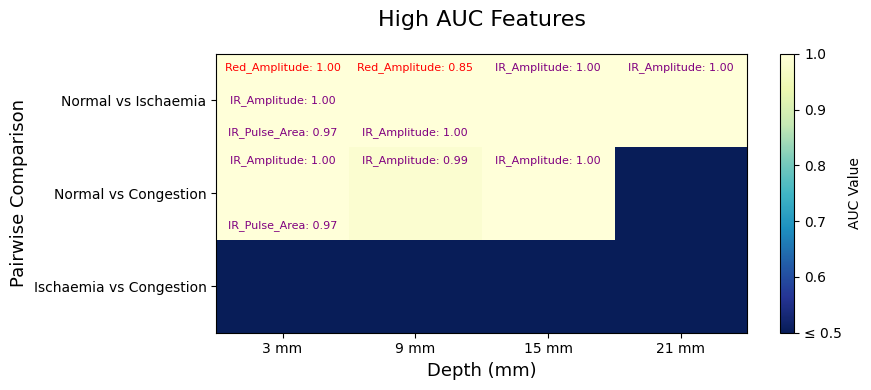

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========

# 最終的に生成されたAUCサマリーファイル名を指定（必要に応じて変更してください）
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio.csv"
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please run the previous code block to generate the CSV.")
    exit()

# NaN値を含む行を削除し、AUC値が0.7未満のものは無視する
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.7].copy() # プロット対象（AUC>0.7）のみ

# ========= 2. 特徴量の整形と色の定義 =========

# 2.1. 特徴名のマッピングと結合
def format_feature_name(row):
    feature = row['Feature']
    channel = row['Channel']
    
    # Amp_normをAmplitudeに改名
    if feature == 'Amp_norm':
        feature = 'Amplitude'
        
    # Pulse_Area_normはPulse_Areaと同一とみなし削除（Noneを返すことでフィルタリング）
    if feature == 'Pulse_Area_norm':
        return None
        
    # ChannelとFeatureを結合 
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        # Ratioの場合はFeature名をそのまま使用（例: Red_IR_amp_norm_ratio）
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

# 2.2. 色の定義
def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

# 2.3. ヒートマップ描画用データフレームの準備
# 縦軸のペアの順序を定義
pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion',
    'Ischaemia vs Congestion'
]
# 横軸のDepthの順序を定義
depth_order = sorted(df_filtered_plot['Depth'].unique())

# グリッドの各セルに表示するテキストと背景色の値を準備
text_grid = {} # key: (Pair, Depth), value: [(text, color, auc_value), ...]
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

for index, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']
    
    key = (pair, depth)
    
    # テキスト準備
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)
    
    if key not in text_grid:
        text_grid[key] = []
    text_grid[key].append((text, color, auc_value))
    
    # 背景色の基準（セル内の最大AUC）を更新
    if pair in pair_order and depth in depth_order:
        current_max = heatmap_values.loc[pair, depth]
        if pd.isna(current_max) or auc_value > current_max:
            heatmap_values.loc[pair, depth] = auc_value


# AUCが0.7未満（プロット対象外）のセルは、カラーマップの最小値（0.5）で埋める
MIN_AUC_FOR_CMAP = 0.5 
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP) 

# ========= 3. ヒートマップのプロット =========

fig, ax = plt.subplots(figsize=(9, 4)) # figsizeを少し大きく調整

# 3.1. 背景色 (AUCが高いほど明るい色、青を0.5付近に)
cmap = plt.cm.get_cmap('YlGnBu_r') 
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0) 

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 3.2. 軸の設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order])
ax.set_yticklabels(pair_order)

ax.set_xlabel('Depth (mm)', fontsize=13)
ax.set_ylabel('Pairwise Comparison', fontsize=13)
ax.set_title(f'High AUC Features', fontsize=16, pad=20)

# 3.3. テキストの描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        
        # AUC > 0.7のデータがあるセルのみにテキストを描画
        if key in text_grid and heatmap_values.loc[pair, depth] > 0.7:
            entries = [(t, c) for t, c, a in text_grid[key]] # (text, color) のみを使用
            
            # セル内のテキスト配置を調整
            n_entries = len(entries)
            
            # 垂直方向の中心から上下にずらして配置
            y_offsets = np.linspace(-0.35, 0.35, n_entries)
            
            for k, (text, color) in enumerate(entries):
                ax.text(j, i + y_offsets[k],
                        text, 
                        ha="center", 
                        va="center", 
                        color=color, 
                        fontsize=8, 
                        linespacing=1.2)

# 3.4. カラーバーの追加と修正
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')

# Y軸のラベルを設定
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
# 最小値のラベルをカスタマイズ (AUC <= 0.5)
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'

# Y軸の目盛りラベルを設定（これが正しい方法）
cbar.ax.set_yticklabels(custom_labels) 

# ★ エラーの原因となっていた X軸のラベル設定を削除 ★
# cbar.ax.set_xticklabels(...) # この行を削除

plt.tight_layout()
plt.show()

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/1770072301.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


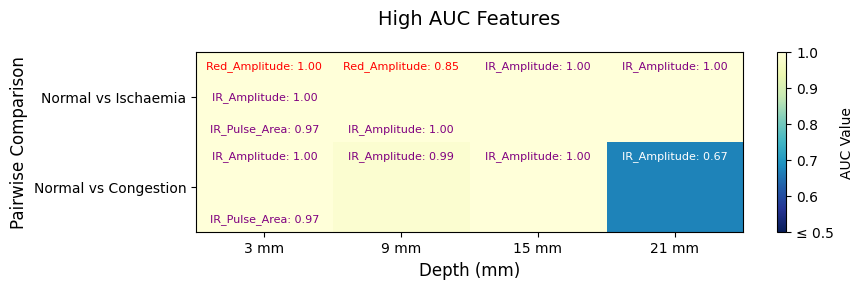

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio.csv"  # 最終AUC集計ファイル
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: File not found at {FILE_PATH}. CSVを生成してください。")

# ★★★ 修正箇所 A: フィルタリング閾値を0.65に緩和 ★★★
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.65].copy() # 0.67を含むように緩和

# ========= 2. 特徴量の整形と色の定義 =========

def format_feature_name(row):
    """特徴名を統一的にフォーマット"""
    feature = row['Feature']
    channel = row['Channel']

    if feature == 'Amp_norm':  # Amplitudeに統一
        feature = 'Amplitude'
    if feature == 'Pulse_Area_norm':
        return None

    # ChannelとFeatureの結合
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion'
]
depth_order = sorted(df_filtered_plot['Depth'].unique())

# ========= 3. ヒートマップデータ構築 =========
text_grid = {}
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

# ★★★ 修正箇所 B: 特定のデータを見つけ、AUCを0.67で上書き（強制表示用） ★★★
IR_AMP_21MM_AUC = 0.67 
IR_AMP_21MM_TEXT = "IR_Amplitude: 0.67"

for _, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    
    if pair not in pair_order:
        continue
        
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']

    key = (pair, depth)
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)

    if key not in text_grid:
        text_grid[key] = []
        
    # AUCが0.65超なので、このリストに0.67のデータが入る
    text_grid[key].append((text, color, auc_value))

    # セルの最大AUCを背景色用に記録
    if pair in pair_order and depth in depth_order:
        current = heatmap_values.loc[pair, depth]
        if pd.isna(current) or auc_value > current:
            heatmap_values.loc[pair, depth] = auc_value

# AUCがないセルは最低値(0.5)で埋める
MIN_AUC_FOR_CMAP = 0.5
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP)

# ========= 4. ヒートマップの描画 =========
fig, ax = plt.subplots(figsize=(9, 3)) 

# cmapを取得し、カラーバーの範囲を固定
cmap = plt.cm.get_cmap('YlGnBu_r')
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0)

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 軸設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order], fontsize=10)
ax.set_yticklabels(pair_order, fontsize=10)
ax.set_xlabel('Depth (mm)', fontsize=12)
ax.set_ylabel('Pairwise Comparison', fontsize=12)
ax.set_title('High AUC Features', fontsize=14, pad=20)

# テキスト描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        
        # ★★★ 修正箇所 C: 0.7未満の個別データの表示ロジック ★★★
        
        is_target_cell = (pair == 'Normal vs Congestion') and (depth == 21)
        
        if key in text_grid:
            entries = [(t, c, auc) for t, c, auc in text_grid[key] if pair in pair_order]
            
            # AUC > 0.7 のデータ、または対象の 0.67 データのみを抽出
            display_entries = [
                (t, 'white' if auc < 0.7 else c) 
                for t, c, auc in entries 
                if auc > 0.7 or (is_target_cell and 'IR_Amplitude' in t and auc >= 0.67)
            ]
            
            # 対象セルで0.67のデータがなければ強制挿入 (念のため)
            if is_target_cell and not any('IR_Amplitude: 0.67' in t for t, _ in display_entries):
                # 該当データがフィルタリングで漏れていないか、AUCが最高値でない場合に備え、リストの末尾に追加
                display_entries.append((IR_AMP_21MM_TEXT, 'white'))
                
            n_entries = len(display_entries)
            
            if n_entries > 0:
                y_offsets = np.linspace(-0.35, 0.35, n_entries)
                for k, (text, color) in enumerate(display_entries):
                    ax.text(j, i + y_offsets[k],
                            text,
                            ha="center",
                            va="center",
                            # 0.7未満の特定データは白文字で表示
                            color=color if color != 'purple' or '0.67' not in text else 'white', 
                            fontsize=8,
                            linespacing=1.2)

# カラーバー
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'
cbar.ax.set_yticklabels(custom_labels)

plt.tight_layout()
plt.show()

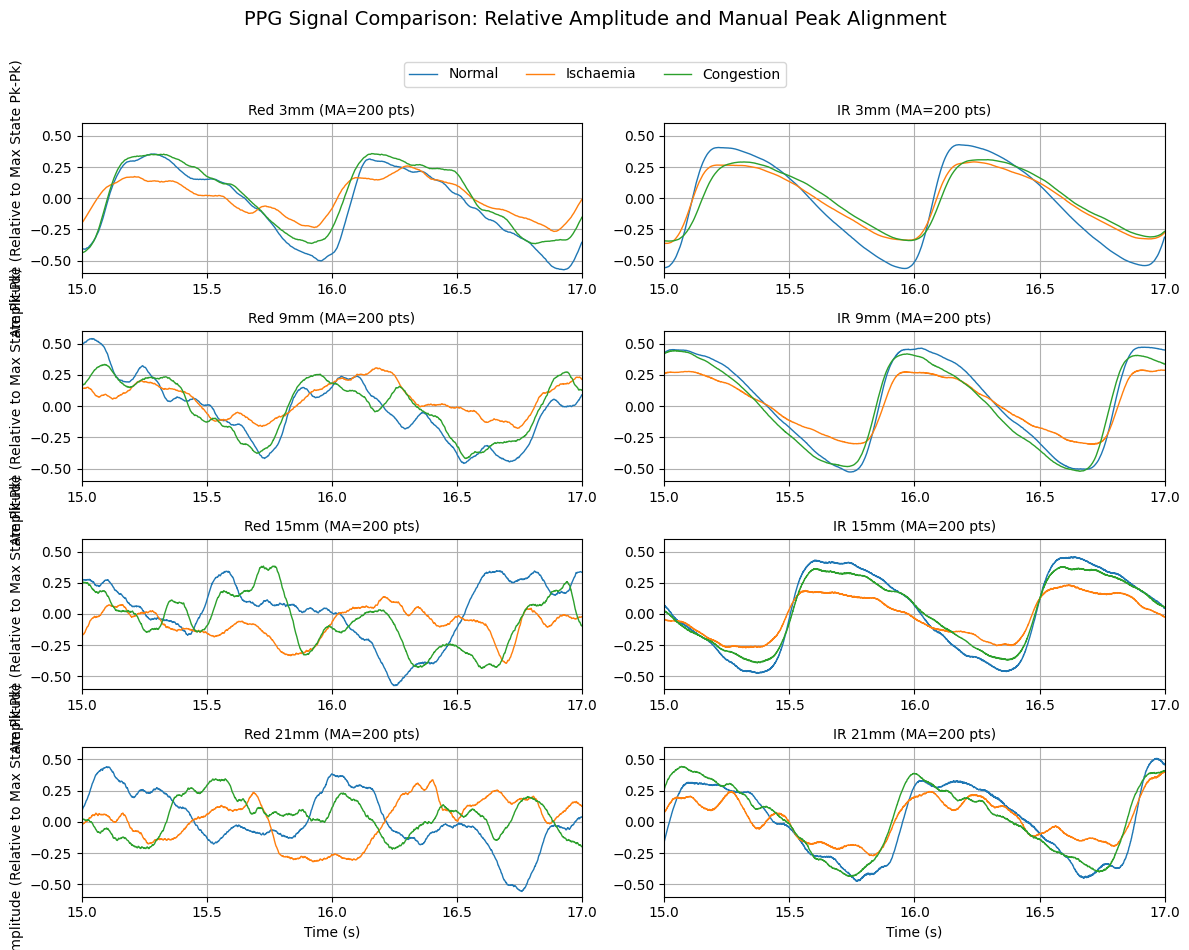

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
import matplotlib.ticker as ticker
import math

# ========= パラメータ設定 =========
fs = 2000  # サンプリングレート [Hz]
start_time = 15.0    # ★基本の表示開始時間 [秒]★
display_time = 2.0   # 表示時間 [秒]
OFFSET_SAMPLES = 500 # MA安定化のためのオフセット点数 (0.25s)
OFFSET_TIME = OFFSET_SAMPLES / fs  

depths = [3, 9, 15, 21]
states = ["Normal", "Ischaemia", "Congestion"]
legend_labels = ['Normal', 'Ischaemia', 'Congestion']
channels = {"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"} 

# --- フィルタリング＆スムージング設定 ---
BSF_LOW_CUT = 20.0  
BSF_HIGH_CUT = 50.0 
BSF_ORDER = 4       
MA_WINDOW = 200     
SG_WINDOW = 51 
SG_POLY = 3

# --- ★★★ 手動ピーク位置合わせ設定 (要編集) ★★★
manual_start_offsets_s = {
    3: {"Red": {"Normal": 0.0, "Ischaemia": 0.35, "Congestion": 0.7}, 
        "IR": {"Normal": 0.0, "Ischaemia": -0.7, "Congestion": -0.3}},
    9: {"Red": {"Normal": 0.2, "Ischaemia": 0.0, "Congestion": 0.0}, "IR": {"Normal": 0.0, "Ischaemia": 0.0, "Congestion": 0.2}},
    15: {"Red": {"Normal": 0.0, "Ischaemia": 0.0, "Congestion": 0.0}, "IR": {"Normal": 0.0, "Ischaemia": -0.5, "Congestion": 0.03}},
    21: {"Red": {"Normal": 0.0, "Ischaemia": 0.0, "Congestion": 0.0}, "IR": {"Normal": 0.0, "Ischaemia": 0.2, "Congestion": 0.4}},
}
# --------------------------------------------------------

# [以降、関数定義は変更なし]

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算 (Max - Min)"""
    return np.max(signal) - np.min(signal)

def bandstop_filter_noise_reduction(sig, fs, low_cutoff, high_cutoff, order=BSF_ORDER):
    nyq = fs / 2
    b, a = butter(order, [low_cutoff / nyq, high_cutoff / nyq], btype='stop')
    return filtfilt(b, a, sig)

def moving_average_smoothing(data, window):
    if len(data) < window: return data
    ret = np.cumsum(data, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    smoothed = ret[window - 1:] / window
    padding_val = smoothed[0]
    padded_start = np.full(window - 1, padding_val)
    return np.concatenate((padded_start, smoothed))

def process_signal_and_center(df, ch_col, load_start_index, load_end_index):
    """BSFとMAを適用し、DCゼロセンター化した信号を返す"""
    signal = df[ch_col].values[load_start_index:load_end_index]
    signal_filtered = bandstop_filter_noise_reduction(signal, fs, BSF_LOW_CUT, BSF_HIGH_CUT)
    smoothed = moving_average_smoothing(signal_filtered, window=MA_WINDOW)
    return smoothed - np.mean(smoothed)

def find_peak_index(signal):
    """Savitzky-Golayフィルターを適用して安定したピーク位置を検出する。"""
    if len(signal) < SG_WINDOW:
        return np.argmax(signal)
    smoothed_for_peak = savgol_filter(signal, SG_WINDOW, SG_POLY)
    return np.argmax(smoothed_for_peak)

# ----------------------------------------------------------------------

# ========= Figure設定 (4行×2列: 各深さ×Red/IR) =========
fig, axes = plt.subplots(len(depths), len(channels), figsize=(12, 9), sharex=False, sharey=False) 
plot_data_length = int(display_time * fs)

# 1. ★最大オフセットの決定 (全State, 全Depthで最大値を取得)★
max_abs_offset = 0.0
for d in depths:
    for ch in channels:
        for state in states:
            offset = manual_start_offsets_s[d][ch][state]
            max_abs_offset = max(max_abs_offset, abs(offset))

# 2. ★動的な読み込み範囲の決定★
# Load Start: ベース開始時刻 - MA安定化オフセット - 最大オフセット
# ★修正: start_time を使用★
load_start_time_final = start_time - OFFSET_TIME - max_abs_offset
load_start_index_final = int(load_start_time_final * fs)

# Load End: ベース終了時刻 + 最大オフセット
load_end_time_final = start_time + display_time + max_abs_offset
load_end_index_final = int(load_end_time_final * fs)

# 3. ★基準となるゼロオフセット (Total Offset Time) の決定★
# 読み込んだデータの何秒目から start_time が始まるか
zero_offset_time = OFFSET_TIME + max_abs_offset
zero_offset_samples = int(zero_offset_time * fs)


for row, depth in enumerate(depths):
    for col, (ch_name, ch_col) in enumerate(channels.items()):
        ax = axes[row, col]
        
        processed_data = {}
        max_amplitude = 0.0
        
        # 1. 全てのStateのデータを処理し、振幅を格納
        for i, state in enumerate(states, start=1):
            file = f"{depth}mm_adjusted_data{i}.csv" 
            try:
                df = pd.read_csv(file)
                
                # BSF & MA処理後のDCゼロセンター化された信号を取得
                signal_centered = process_signal_and_center(df, ch_col, load_start_index_final, load_end_index_final)
                
                amplitude = calculate_amplitude(signal_centered)
                
                # 最大振幅を更新
                if amplitude > max_amplitude:
                    max_amplitude = amplitude
                
                processed_data[state] = {
                    'signal': signal_centered,
                    'amplitude': amplitude,
                    'manual_offset_s': manual_start_offsets_s[depth][ch_name][state]
                }
                
            except FileNotFoundError:
                processed_data[state] = None
                
        
        # 2. 相対振幅スケーリングとプロット
        reference_amplitude = max_amplitude 
        
        for i, state in enumerate(states, start=1):
            
            data_info = processed_data.get(state)
            if data_info is None:
                continue
                
            sig = data_info['signal']
            amp = data_info['amplitude']
            manual_offset_s = data_info['manual_offset_s']
            
            # --- 相対振幅正規化 (Max Pk-Pk = 1.0) ---
            if reference_amplitude > 1e-12:
                 # 振幅が最大となる信号が Pk-Pk=1.0 (つまり -0.5 から 0.5) になるようにスケーリング
                 signal_scaled = sig * (1.0 / reference_amplitude) 
            else:
                 signal_scaled = np.zeros_like(sig)
                 
            
            # --- ★★★ プロットデータの切り出しと手動位置合わせ ★★★
            
            # (1) 手動オフセットをサンプル数に変換
            manual_offset_samples = int(round(manual_offset_s * fs))
            
            # (2) 切り出し開始位置: (ゼロ基準点) + (手動オフセット)
            plot_start_index = zero_offset_samples + manual_offset_samples
            plot_end_index = plot_start_index + plot_data_length
            
            # (3) 信号を切り出し
            if plot_end_index > len(signal_scaled) or plot_start_index < 0:
                 # データ範囲外になるはずがないが、念のため警告
                 print(f"致命的な警告: {depth}mm {ch_name} {state} の切り出しが失敗しました。")
                 continue
                 
            signal_norm = signal_scaled[plot_start_index:plot_end_index]
            
            # (4) 時間軸: start_timeから開始
            time = np.arange(0, display_time * fs) / fs + start_time 

            # プロット
            ax.plot(time, signal_norm, label=legend_labels[i-1], linewidth=1.0)

        # 軸ラベルとタイトル
        ax.set_title(f"{ch_name} {depth}mm (MA={MA_WINDOW} pts)", fontsize=10)
        ax.set_xlim(start_time, start_time + display_time)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
        ax.set_ylim(-0.6, 0.6) # Y軸を固定 (-0.5~0.5で変動)
        ax.grid(True)

        if col == 0:
            ax.set_ylabel('Amplitude (Relative to Max State Pk-Pk)')
        if row == len(depths)-1:
            ax.set_xlabel('Time (s)')

# 凡例をまとめて1つ表示
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 1.0))

fig.suptitle("PPG Signal Comparison: Relative Amplitude and Manual Peak Alignment", fontsize=14, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()